Для начала необходимо построить и проанализировать график временного ряда. Построенный график будем анализировать на наличие сезонностей, аномалий, а также посмотрим на тренд

c:\Users\baran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

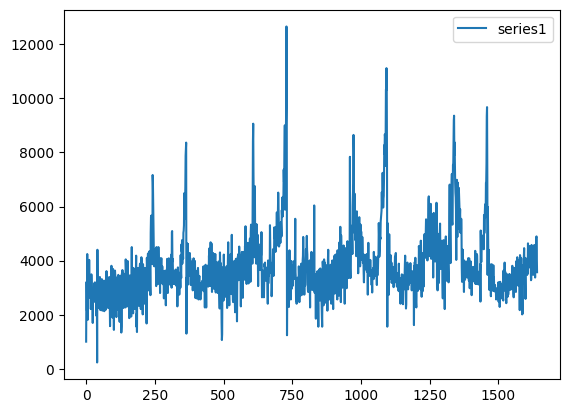

In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


data = pd.read_excel('Задания_1_2.xlsx', sheet_name='Timeseries')
data.plot()

по графику видно два основных подъёма: на первое сенятря и Новый год. В начале ряда можно заметить аномалию, её мы удалим из ряда в процессе подготовки данных. Теперь можно переходить к выбору модели. На мой взгляд, самым простым решением будет использовать библиотеку prophet, так как она даёт возможности учитывать сезонные тренды и праздники

In [3]:
data = data.rename(columns={'Date': 'ds', 'series1': 'y'})
data.loc[data['y'] < 1000, 'y'] = data['y'].median()

new_year = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.to_datetime(['2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31']),
    'lower_window': -5,  
    'upper_window': 2})

edu_day = pd.DataFrame({
    'holiday': 'edu_day',
    'ds': pd.to_datetime(['2015-09-01', '2016-09-01', '2017-09-01', '2018-09-01']),
    'lower_window': -2,  
    'upper_window': 1 })

сформируем модель. Будем делить данные в соотношении 80/20. Гиперпараметры были подобраны экспериментально. Также экспериментально выяснил, что существует небольшая месячная сезонность. После её добавления получилось немного уменьшить ошибку прогноза. 

In [12]:
model = Prophet(
    yearly_seasonality=True,   
    weekly_seasonality=True,  
    daily_seasonality=False,   
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=20,
    holidays= pd.concat([new_year, edu_day]))

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

length = int(len(data)*0.8)
train, test = data[:length], data[length:]

теперь обучим модель и проверим её на тестовой выборке, далее построим график. В качестве критериев качества я решил выбрать MAPE и MAE. 

In [10]:
model.fit(train)
prediction = model.predict(test)
mae = mean_absolute_error(test['y'], prediction['yhat'])
mape = mean_absolute_percentage_error(test['y'], prediction['yhat'])
print(f"MAPE: {round(mape*100, 2)} %, MAE: {round(mae, 2)}")

17:18:40 - cmdstanpy - INFO - Chain [1] start processing
17:18:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.88 %, MAE: 665.06


Построим график и проанализируем его

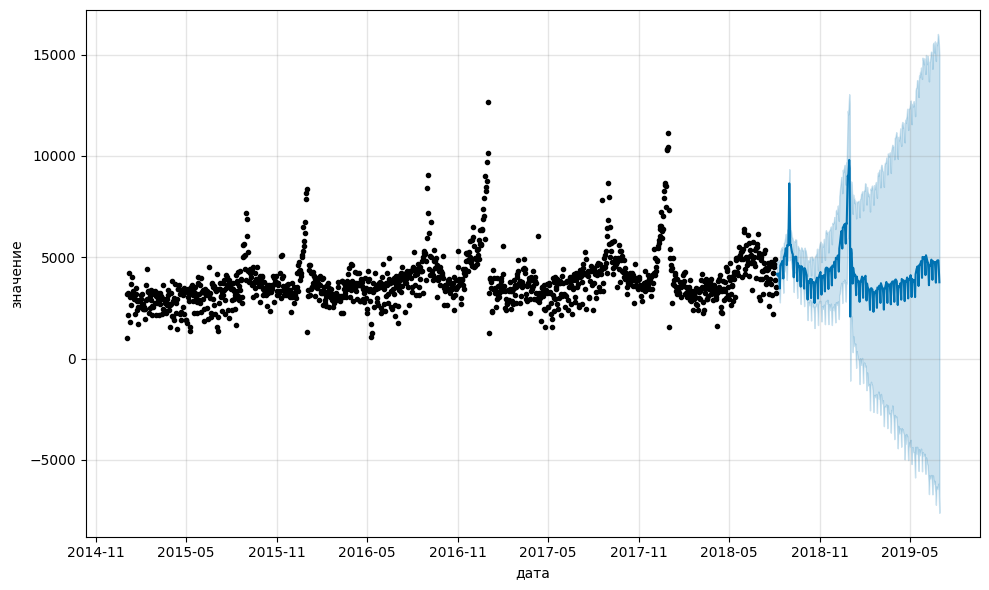

In [11]:
model.plot(prediction, xlabel='дата', ylabel='значение')
plt.show()

Прогноз модели в целом верный: видим на графике два сезонных тренда: небольшой рост к первому сентября и рост побольше к Новому году. Однако исходя из анализа метрик видно, что процент ошибки достаточно велик, поэтому можно попробовать улучшить результат. 

Теперь обучим модель на всей выборке и построим прогноз на следующие 90 дней

17:18:58 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing


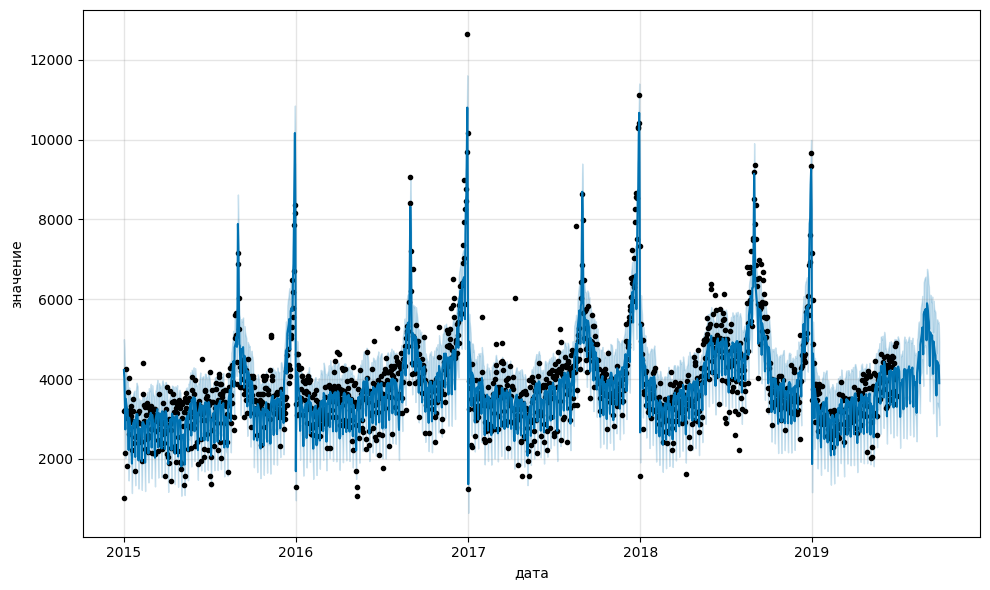

In [13]:
model.fit(data)
future = model.make_future_dataframe(periods=90)
prediction = model.predict(future)
model.plot(prediction, xlabel='дата', ylabel='значение')
plt.show()

видно, что на предсказанной части графика также есть небольшой тренд для первого сентября

In [14]:
prediction = pd.DataFrame({'Date': prediction['ds'][-90:], 'series1': prediction['yhat'][-90:]})
prediction.to_csv('prediction.cvs', index=False)
prediction_vec = list(prediction['series1'])